In [16]:
from utils import get_dataset, PairGenerator, test_embedding, visualize_deformation, plot_losses
from networks import pairwise_embedding_encoder, get_embedding_model, pairwise_embedding_network, get_encoding_model, create_autoencoder, resnet_embenc
from losses import contrastive_loss, reconstruction_loss
from training import train_network
from tensorflow.keras.utils import plot_model
from keras.optimizers import Adam
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd 
import datetime
from joblib import Parallel, delayed
import cv2

In [17]:
def label_plot(data, embedding, labels, num_images, mu):
    # subsample a section of both dataframes in a stratified fashion. 
    img_w, img_h = 28, 28
    zoom = 0.5
    inds = [] 
    # for each class, select 200 images per class. 
    for cl in set(labels):
        cl_inds = np.random.choice(np.where(labels == cl)[0],
                                   num_images,
                                   replace=False)
        inds.extend(cl_inds)

    # filter the data to obtain the images selected for each class. 
    plt_trainX = pd.DataFrame(data.reshape(-1, data.shape[-1])[inds, :]).reset_index(drop=True)
    plt_embedding = embedding[inds, :]

    fig, ax = plt.subplots(figsize=(24,16))

    # plot the image at the position corresponding to the embedding. 
    for i, row in plt_trainX.iterrows():
        image = row.values.reshape((img_w, img_h))
        im = OffsetImage(image, zoom=0.4)
        ab = AnnotationBbox(im, (plt_embedding[i, 0], plt_embedding[i, 1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(embedding[i, 0], embedding[i, 1])])
        ax.autoscale()
    
    plt.title("Label Plot: mu=%s" % mu)
    plt.show()

In [47]:
#### Dataset Processing ###
## select dataset and load. 
def training_loop(mu, data_name='mnist', model_name='resnet'):
    print('training with mu = %s' % mu)
    name = data_name
    size = 50000
    X, Y = get_dataset(name, size)

    ## Specific modifications to MNIST. 
    if name == 'mnist':
        target = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        inds = np.where(np.isin(Y, target))[0]
        X = X[inds, :].astype(np.float64) 
        Y = Y[inds].astype(int)
        X = X/255.

        if model_name == 'resnet':
            X = X.reshape(-1, 28, 28)
            X = np.pad(X, ((0, 0), (2, 2), (2, 2)))
            X = X.reshape(-1, 32, 32)
            X = np.stack([X, X, X], axis=-1)
            print("X.shape: ", X.shape)

    ## train-test split
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25, shuffle=True, stratify=Y)

    ## reshape to match input requirements. 
    if model_name is None:
        trainX = trainX.reshape(-1, 1, trainX.shape[1])
        testX = testX.reshape(-1, 1, testX.shape[1])

    print('training size: ', trainX.shape)
    print('testing size: ', testX.shape)
    ##############################


    ######## EmbEnc Network Params #########
    ## define training params. 
    margin = 5
    p_norm = 2 
    batch_size = 32

    ## specify model parameters and losses. 
    model_type = 'embenc'
    optimizer = Adam(learning_rate=0.005)
    activation = 'relu'
    num_neurons = None
    output_dim = 2
    input_dim = (32, 32, 3) if model_name is 'resnet' else (1, 784)
    loss1 = lambda y_true, y_pred: contrastive_loss(y_true, y_pred, margin=margin, norm=p_norm)
    loss2 = lambda y_true, y_pred: reconstruction_loss(y_true, y_pred)
    losses = {'reconstruction': loss2,
            'embedding': loss1}
    epochs = 5
    max_iters = 1500


    ####### Initializing Network and DataGenerator #######
    ## create generator

    X_train = trainX.reshape(-1, trainX.shape[-1]) if model_name is None else trainX 
    tripgen = PairGenerator(X_train, trainY)

    ## create the model. 
    if model_type == 'embenc':
        embedding_layers = [100, 50, 30, 15]
        autoencoding_layers = [100]
        if model_name == 'resnet':
            model = resnet_embenc(input_dim, output_dim, f=activation, optimizer=optimizer,
                                  losses=losses,
                                  mu=mu,
                                  autoencoding_layers=autoencoding_layers,
                                  embedding_layers=embedding_layers,
                                  prior_trainable=False,
                                  drop_pooling=False)
        else:
            model = pairwise_embedding_encoder(input_dim, output_dim, num_neurons=num_neurons,
                                               losses=losses, optimizer=optimizer, f=activation,
                                               mu=mu, 
                                               embedding_layers=embedding_layers,
                                               autoencoding_layers=autoencoding_layers,
                                               tied_weights=False,
                                               dropout_val=0.0)
    elif model_type == 'siamese':
        model = pairwise_embedding_network(input_dim, output_dim, num_neurons=num_neurons, 
                                        loss=loss1, optimizer=optimizer, f=activation,
                                        dropout_val=0.0, embedding_layers=embedding_layers)

    ## visualize model topology. 
    m1 = plot_model(model, 'full_model.png', expand_nested=True, show_shapes=True)
    m2 = plot_model(model.get_layer('encodingnet'), 'encodingnet.png', expand_nested=True, show_shapes=True)
    m3 = plot_model(model.get_layer('embeddingnet'), 'embeddingnet.png', expand_nested=True, show_shapes=True)


    ########### Train/Visualize Network ############
    print("---------- Training Model ------------")
    start = datetime.datetime.now()
    print("max iters: ", max_iters)
    model, loss_vals = train_network(model, tripgen, batch_size, max_iters, type_=model_type)
    elapsed = datetime.datetime.now() - start
    print("-------- done. elapsed: %s --------" % elapsed)
    ### plot loss ###
    plot_losses(loss_vals)

    ## get the embedding model from the siamese network.
    embedding_model = get_embedding_model(model, input_dim=input_dim)
    embedding = embedding_model.predict(testX) 
    embedding = embedding.reshape(-1, output_dim)

    return (embedding, testX, testY)


In [48]:
## visualize the embedding obtained. 
def plot_embedding(embedding, testY, mu):
    plt.figure(figsize=(24,16))
    for cl in set(testY):
        inds = np.where(testY == cl)[0]
        data = embedding[inds, :]
        plt.scatter(data[:, 0], data[:, 1], label=cl)
    plt.legend()
    plt.title('Embedding: mu = %s' % mu)
    plt.show()

In [ ]:
import multiprocessing as mp
all_results = []
# mu_vals = [0, 0.25, 0.5, 0.9, 0.95, 0.99, 0.995, 1]
mu_vals = [0.75]
results = training_loop(0.75, data_name='mnist', model_name='resnet')
# pool_ = mp.Pool(len(mu_vals))
# results = pool_.map(training_loop, mu_vals, chunksize=1)
# all_results.append(results)

training with mu = 0.75


In [51]:
embedding, testX, testY = results

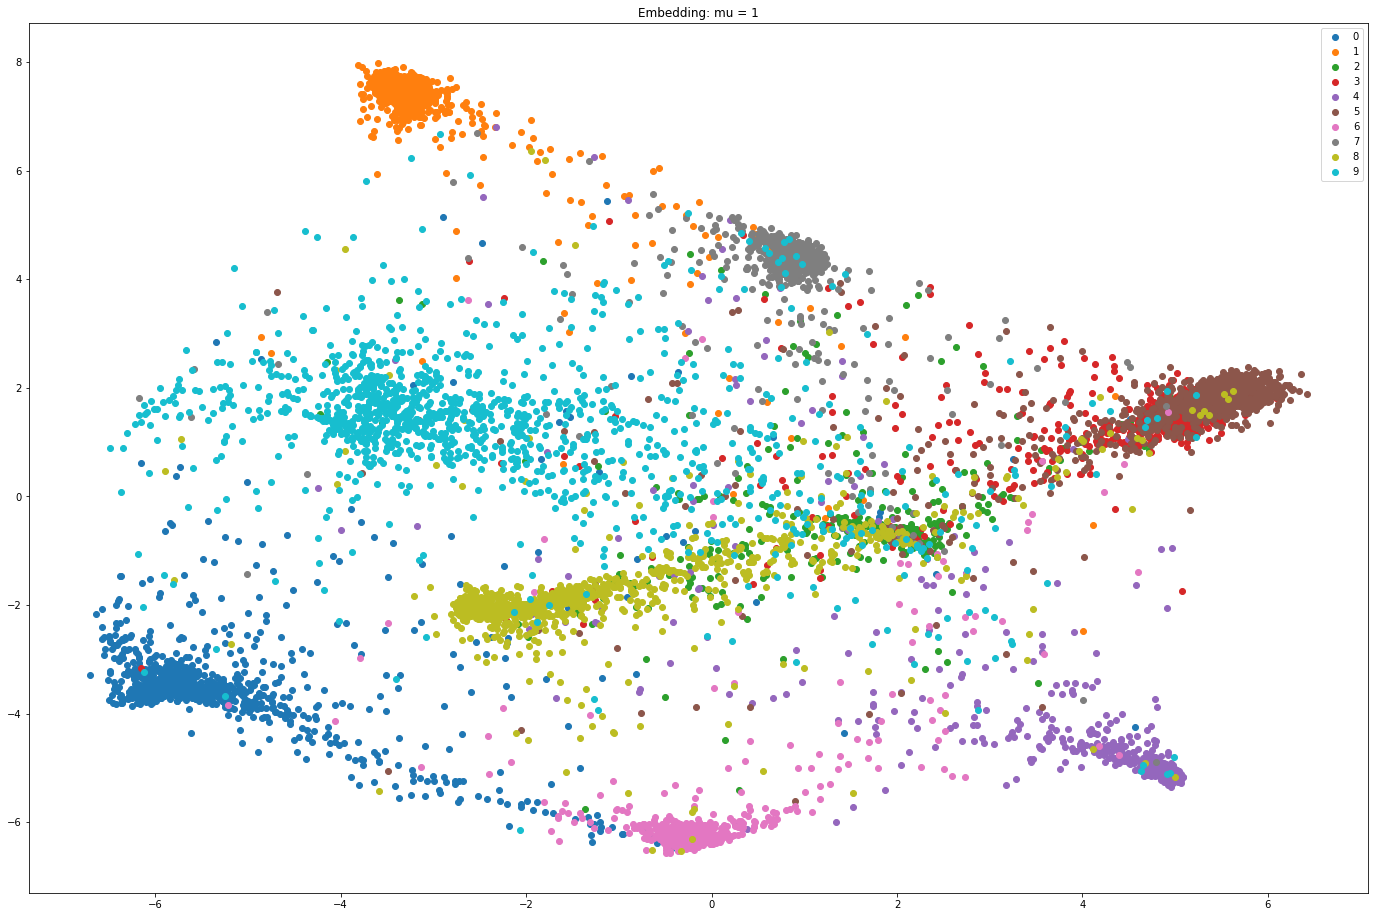

In [52]:
plot_embedding(embedding, testY, 1)

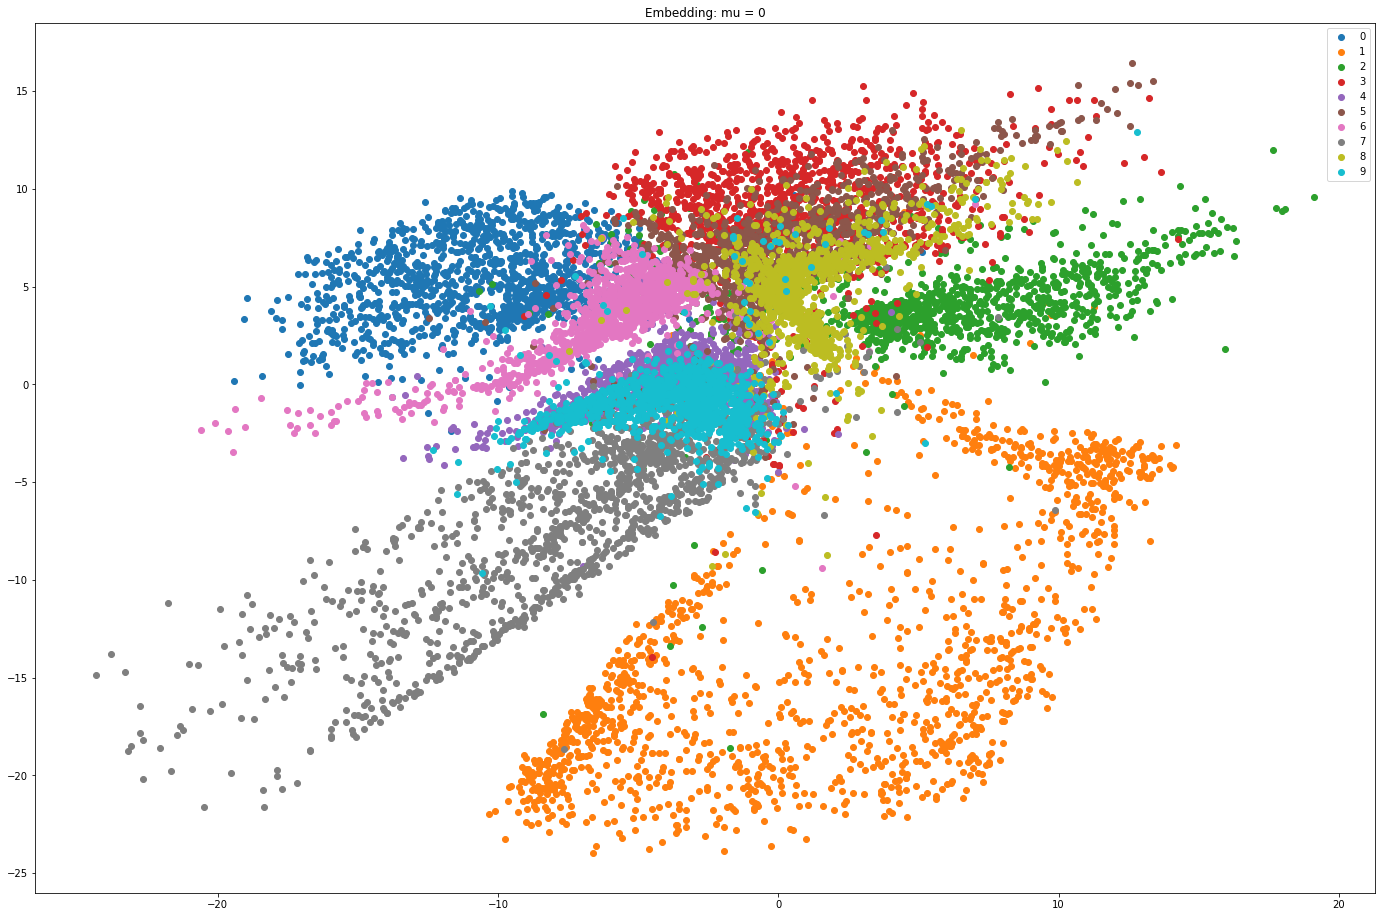

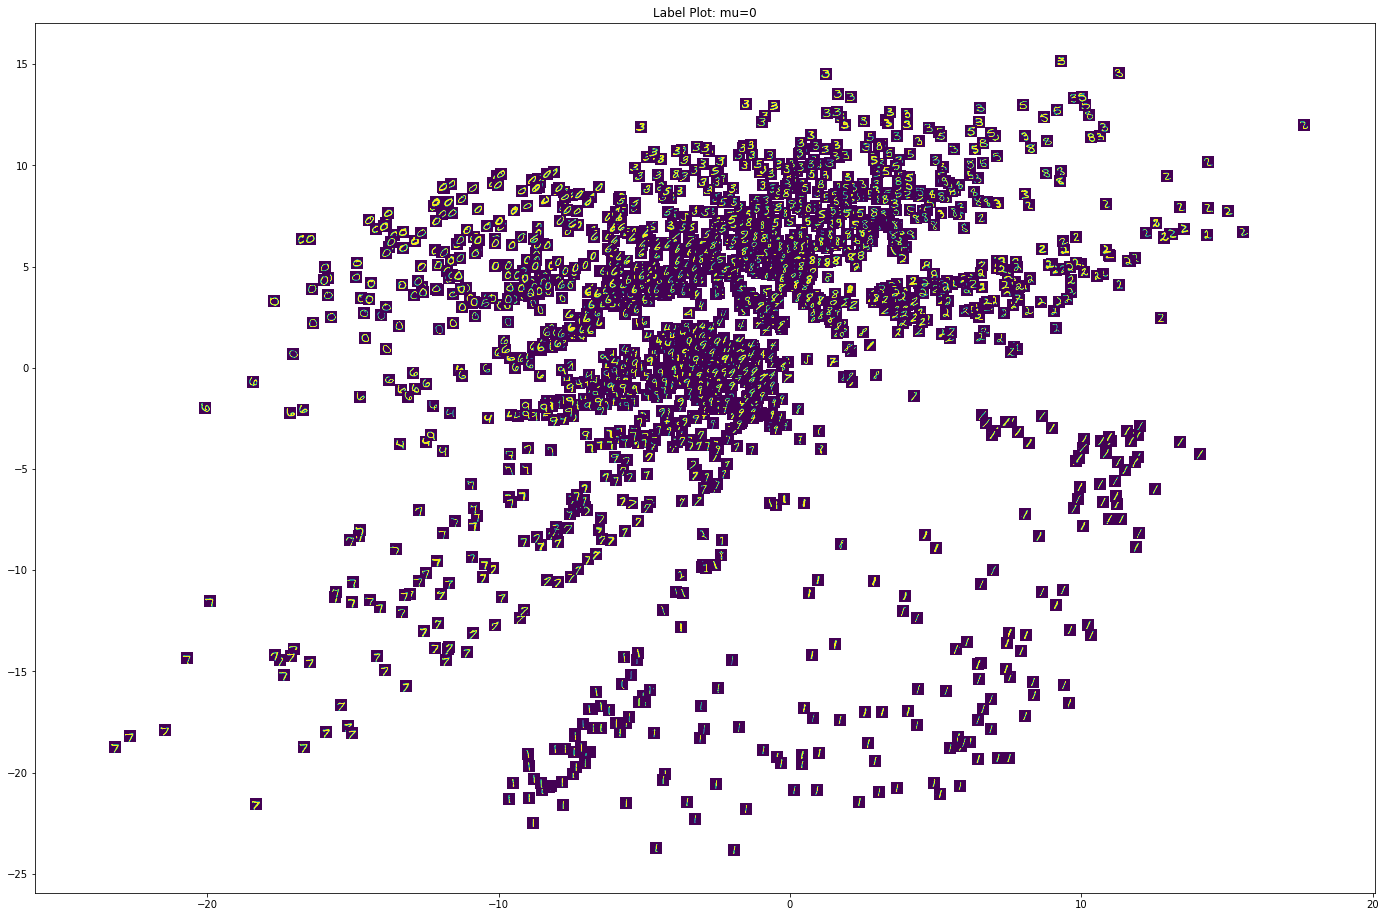

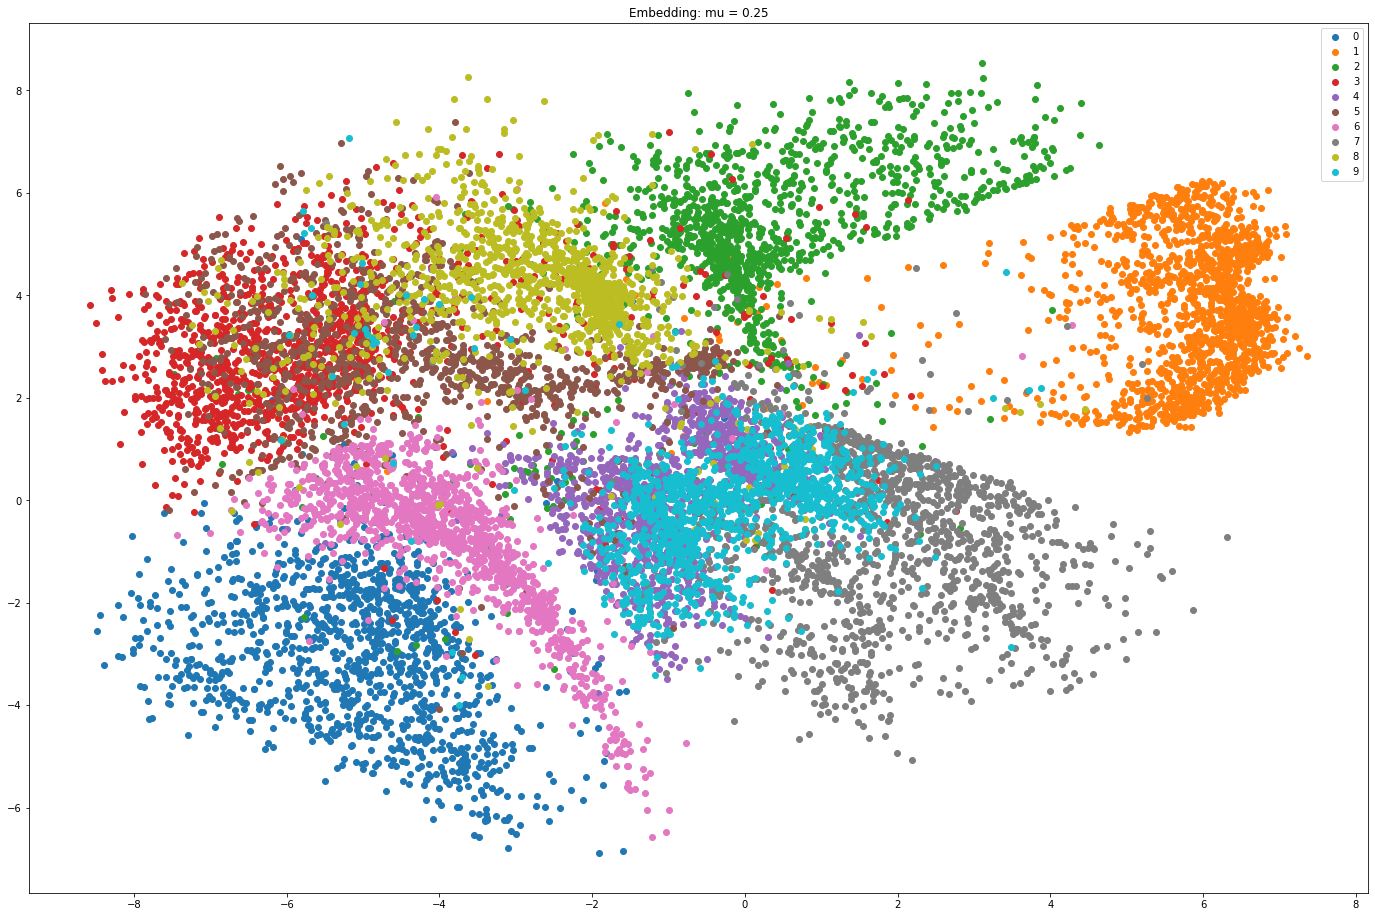

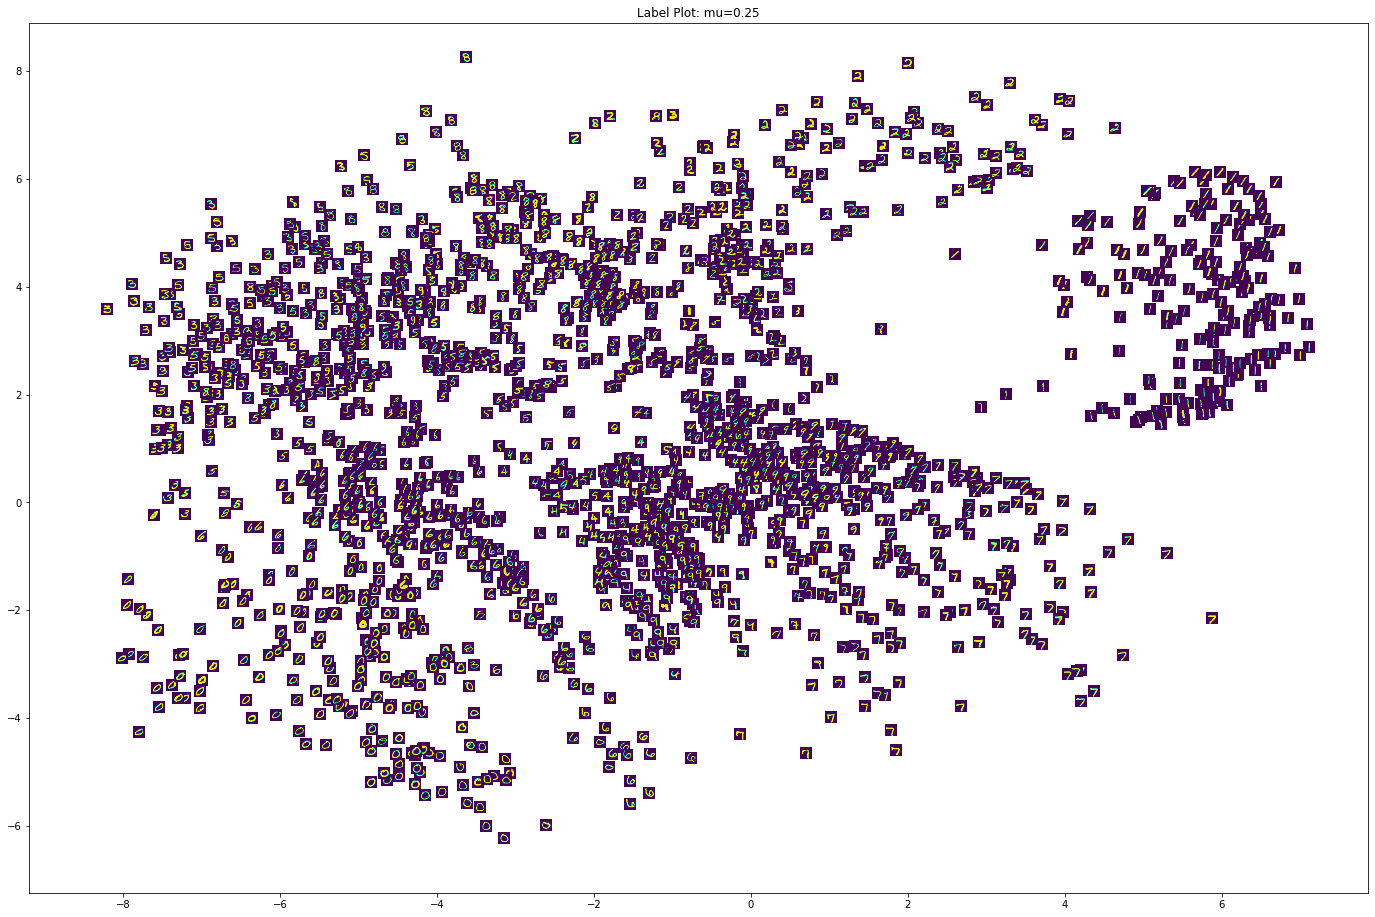

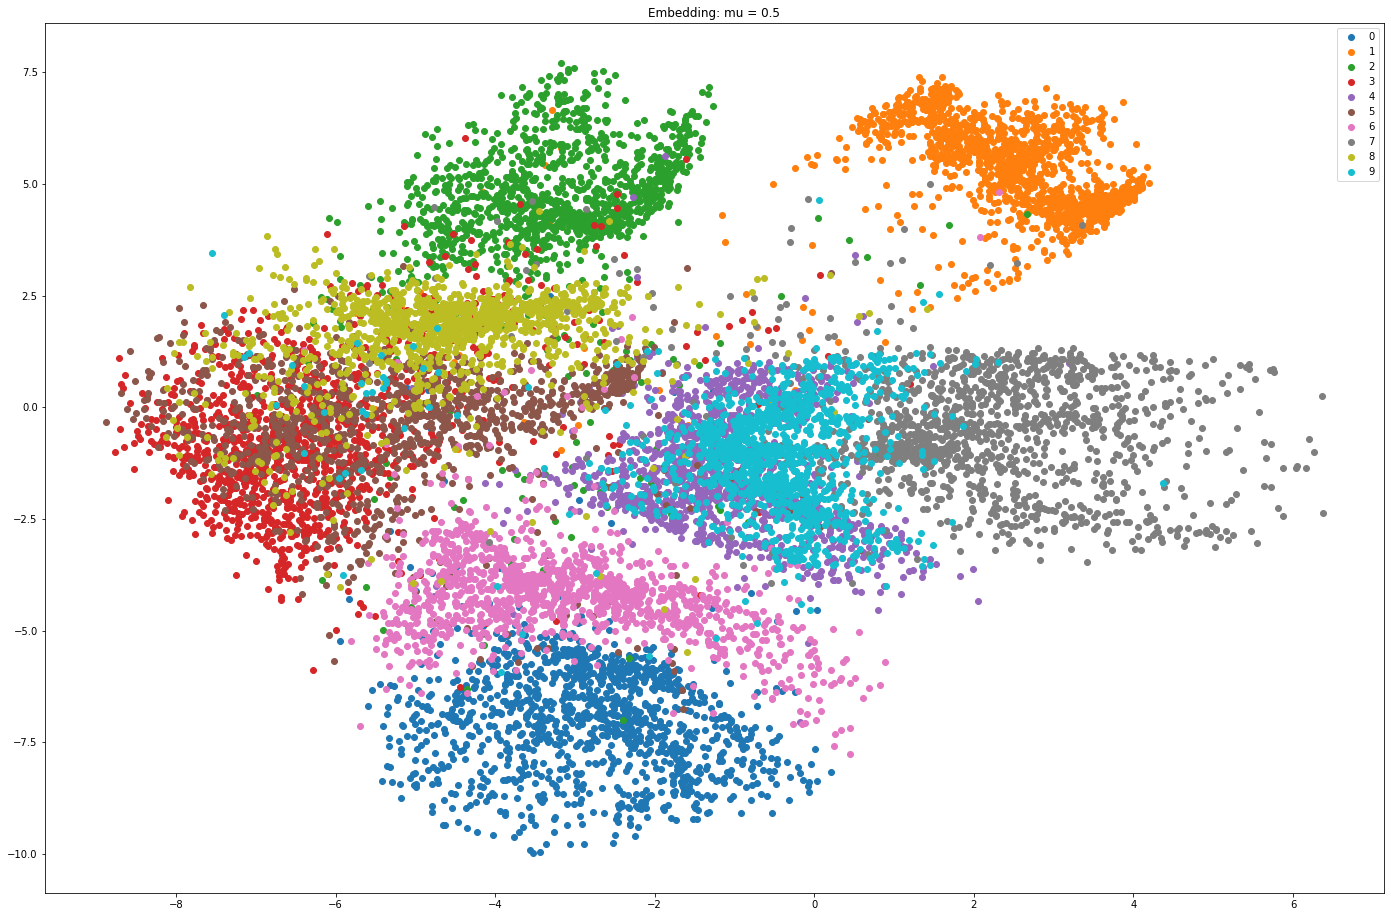

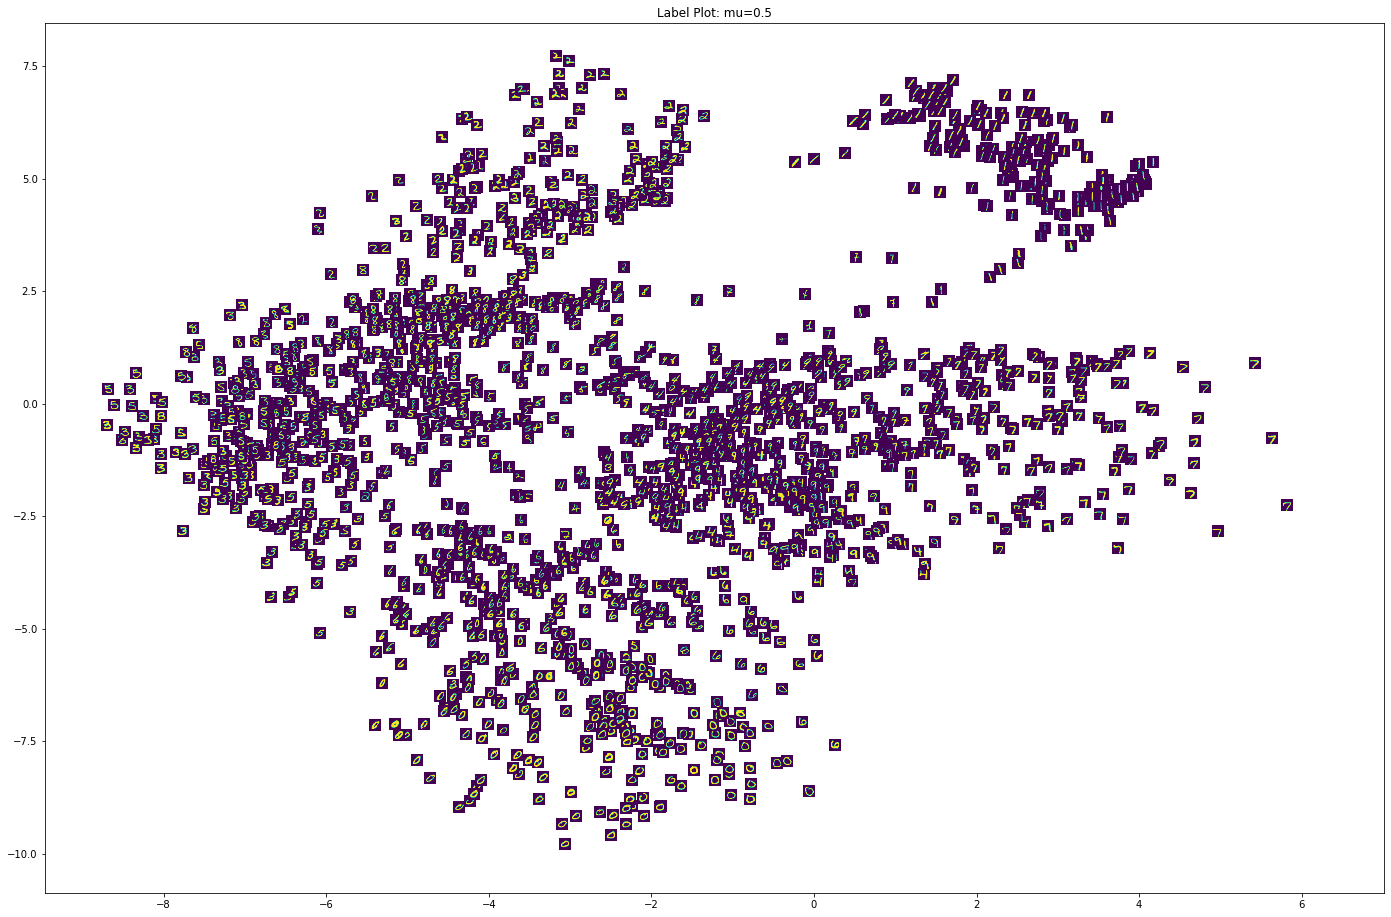

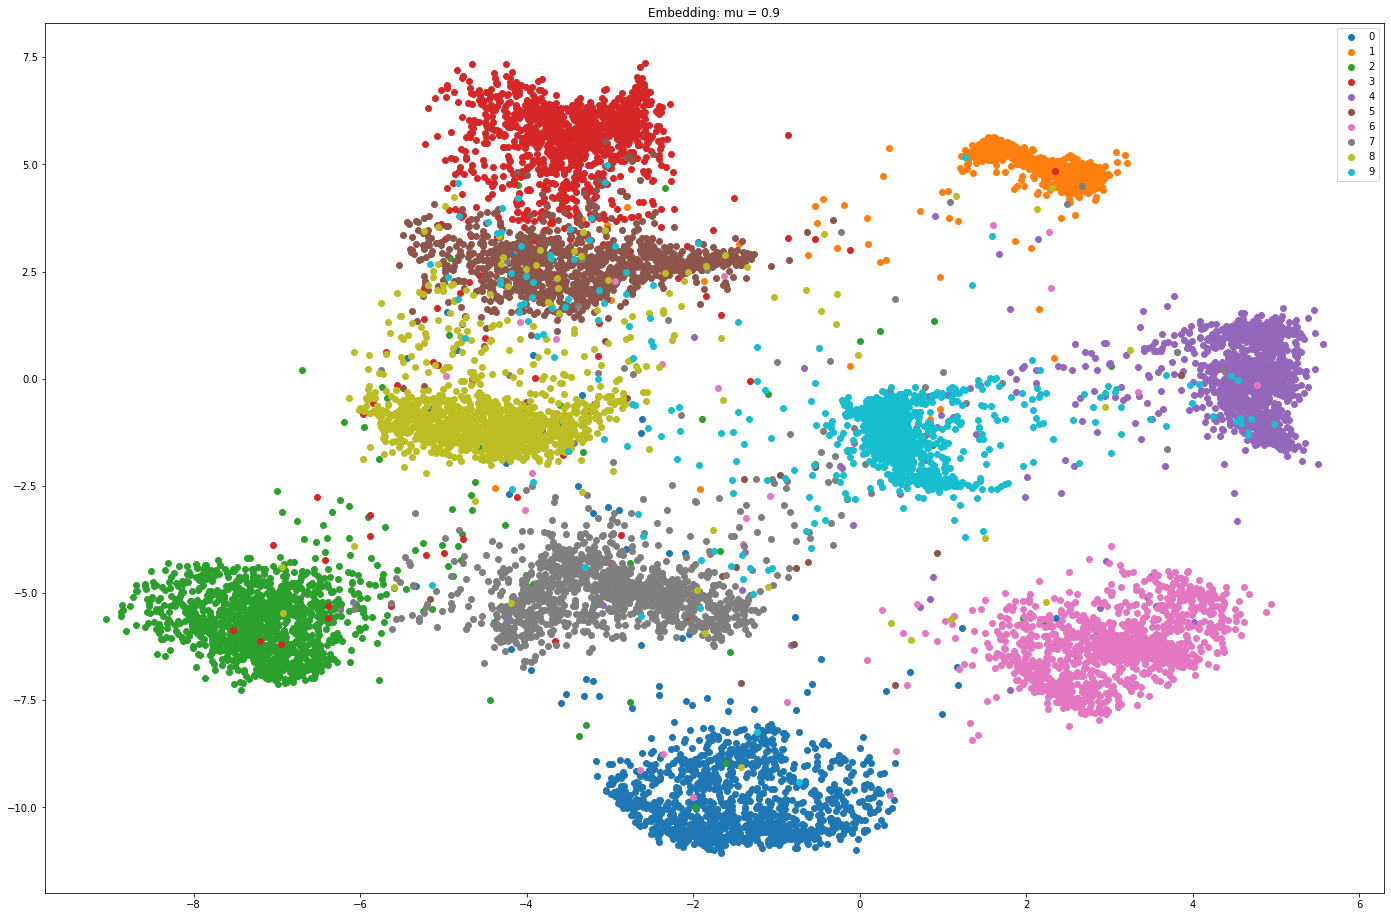

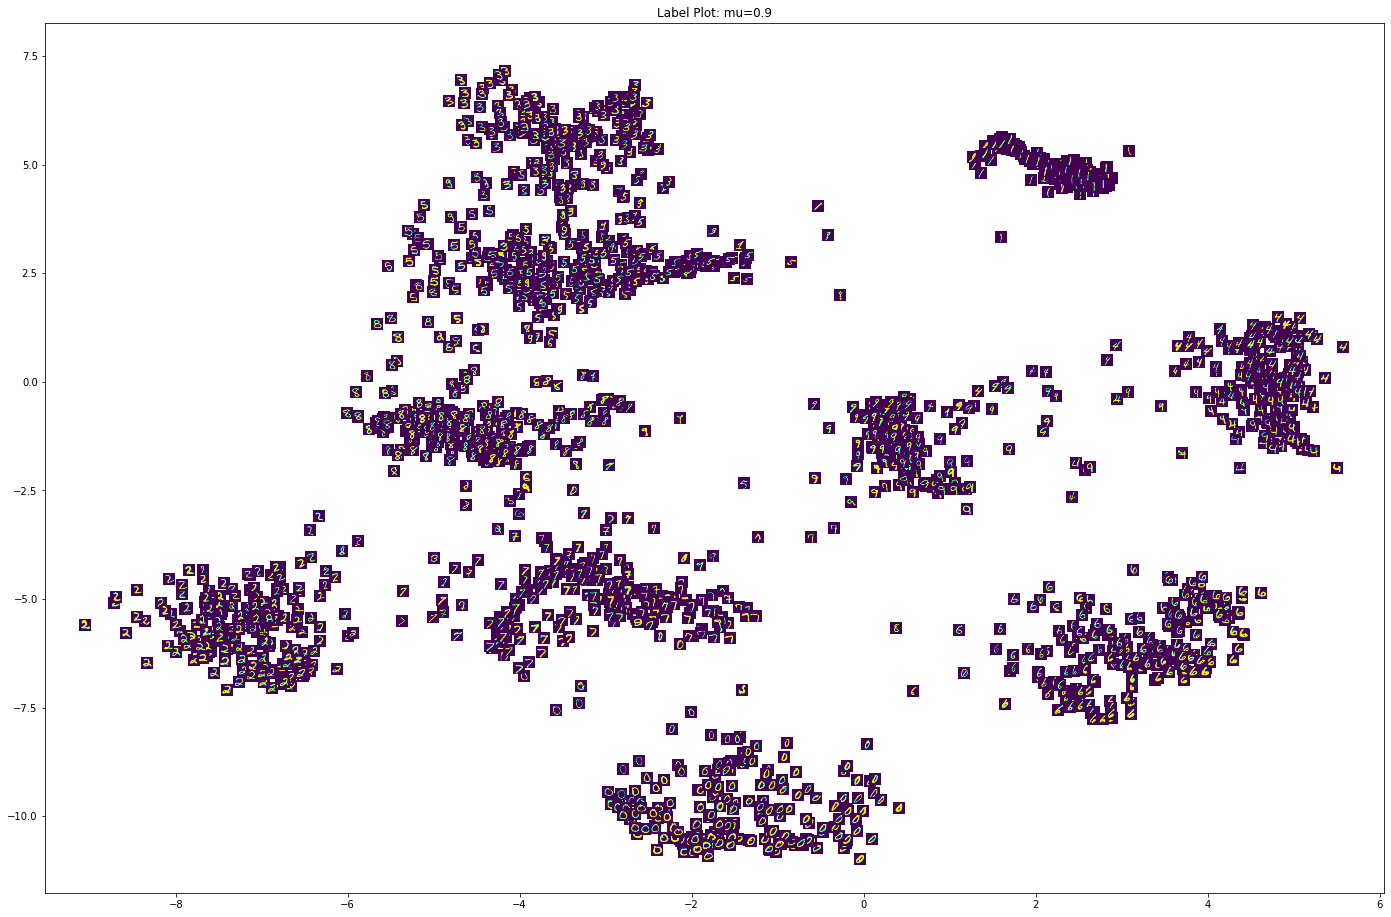

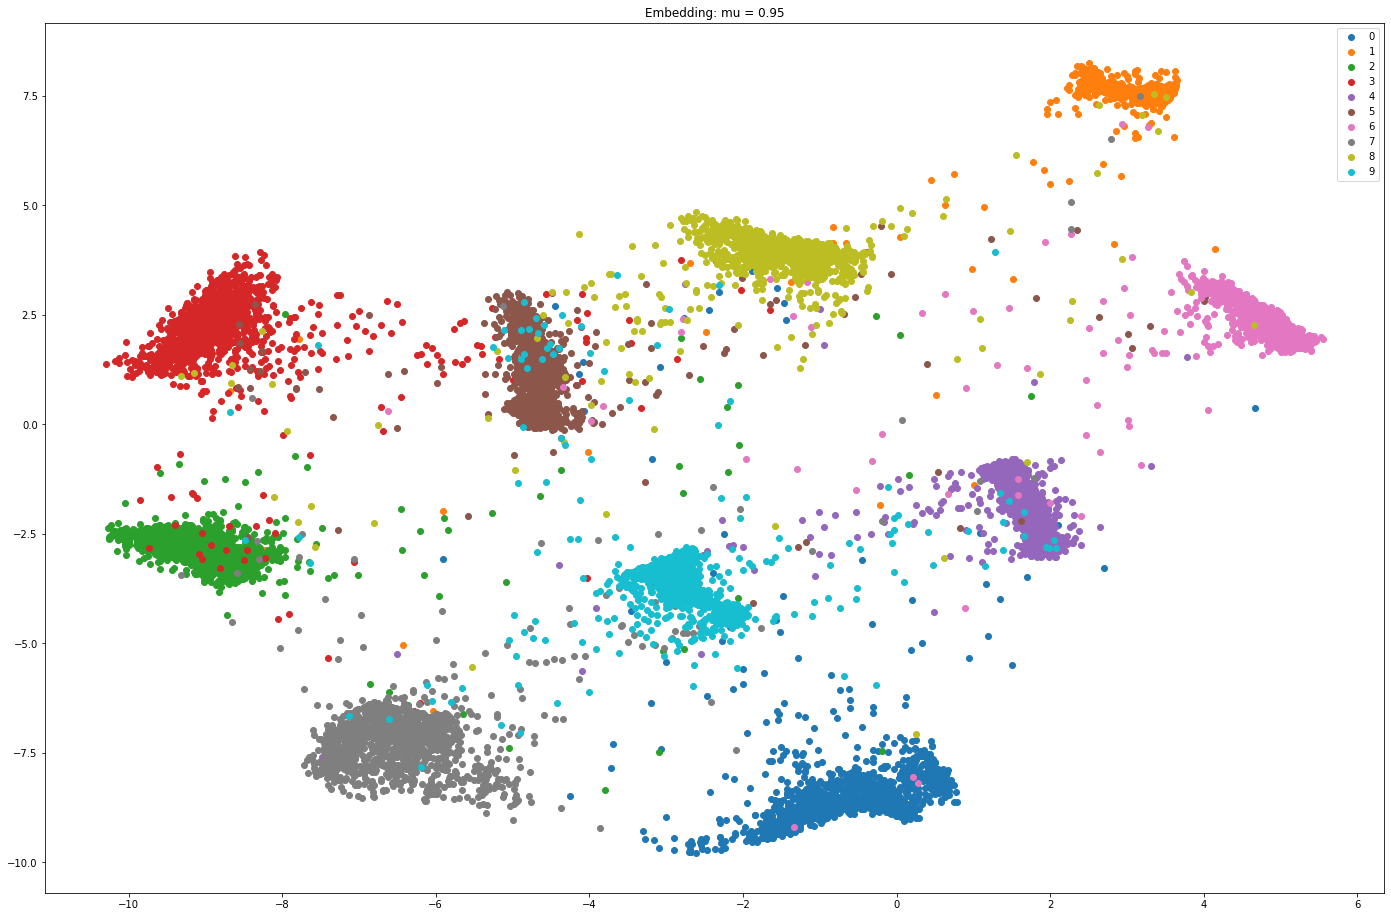

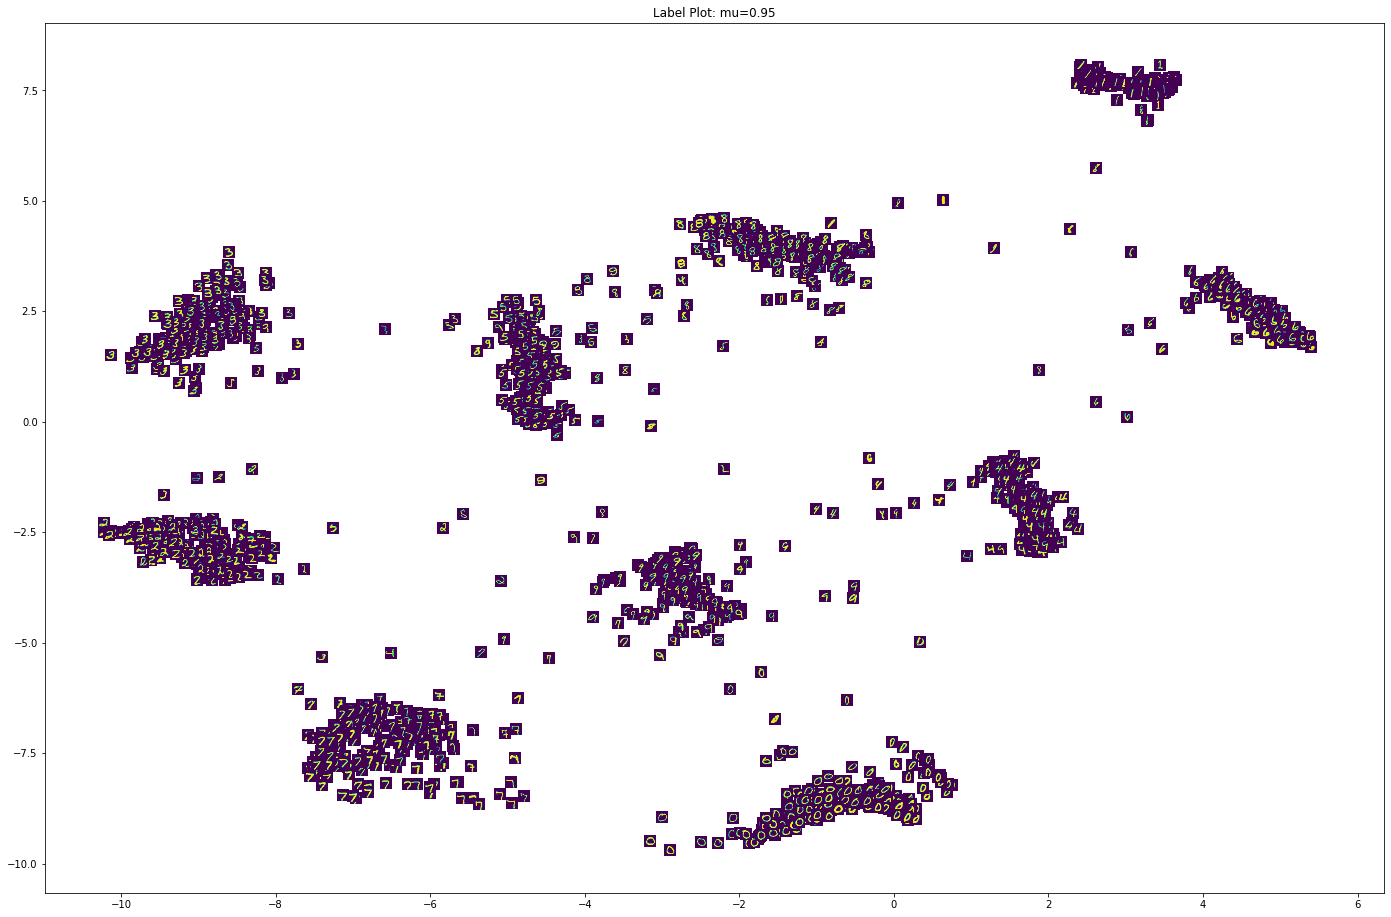

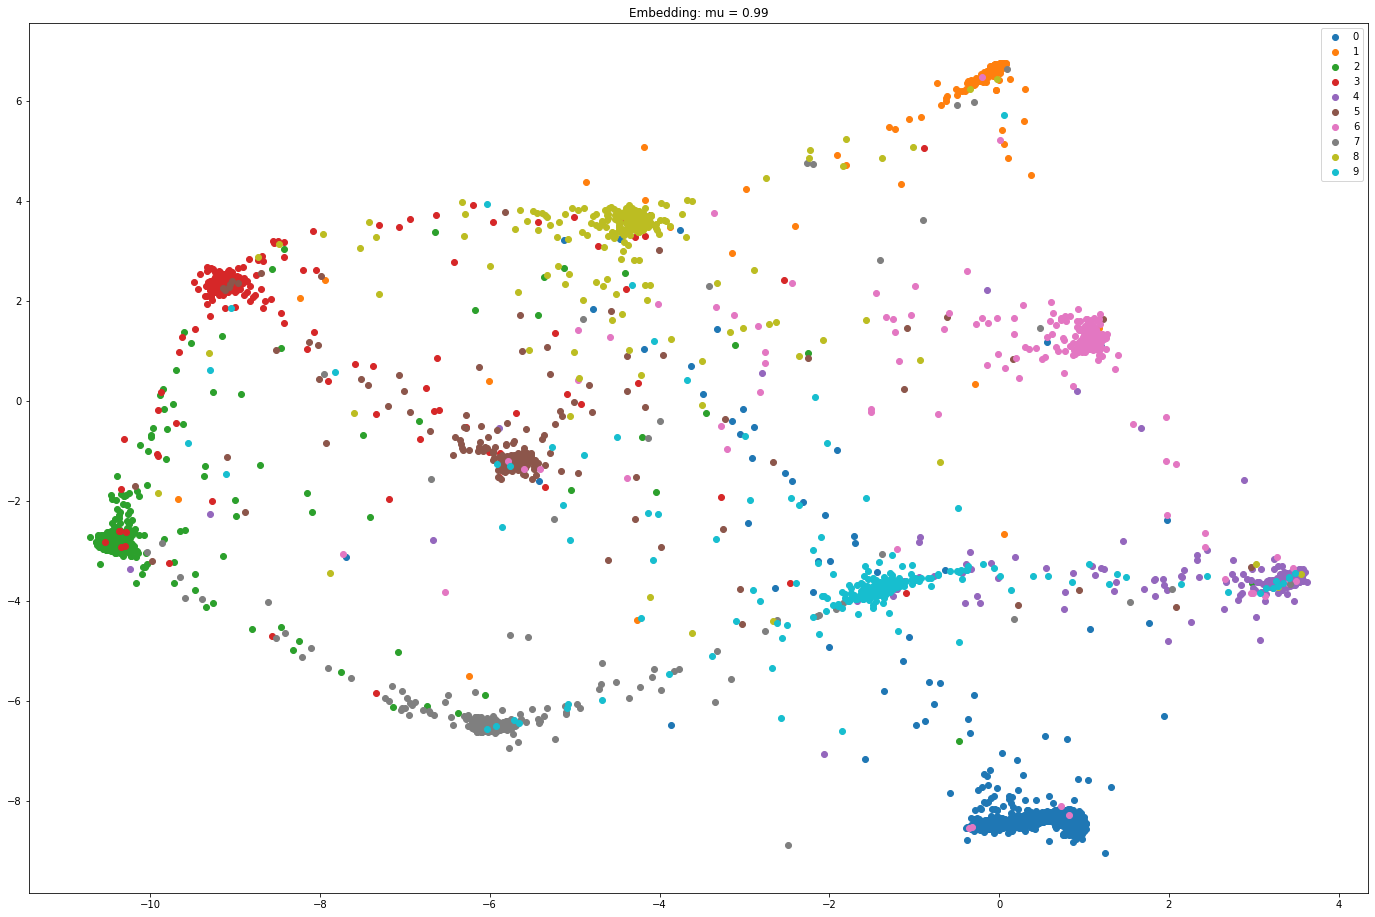

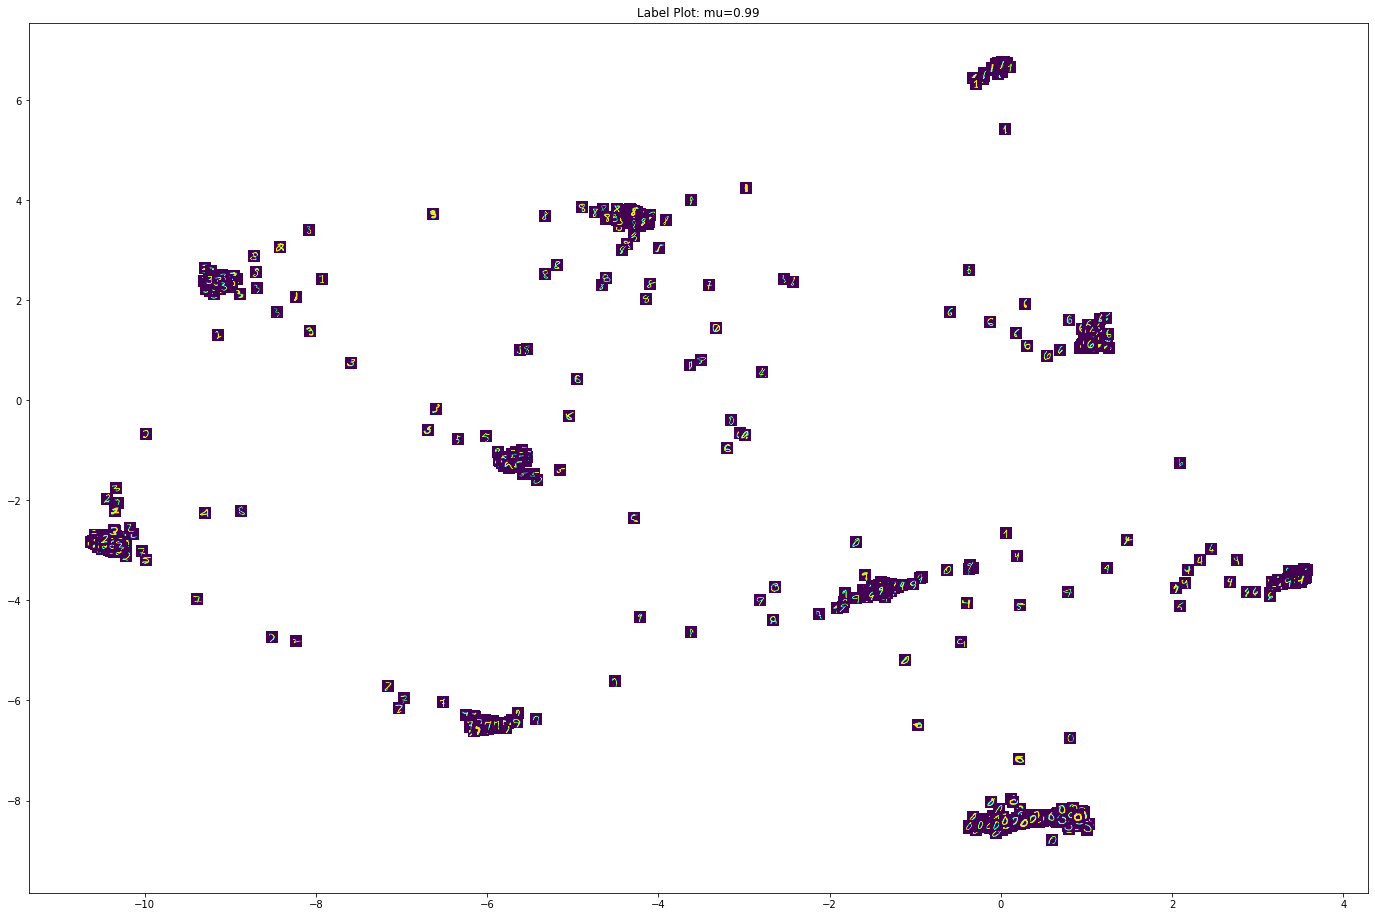

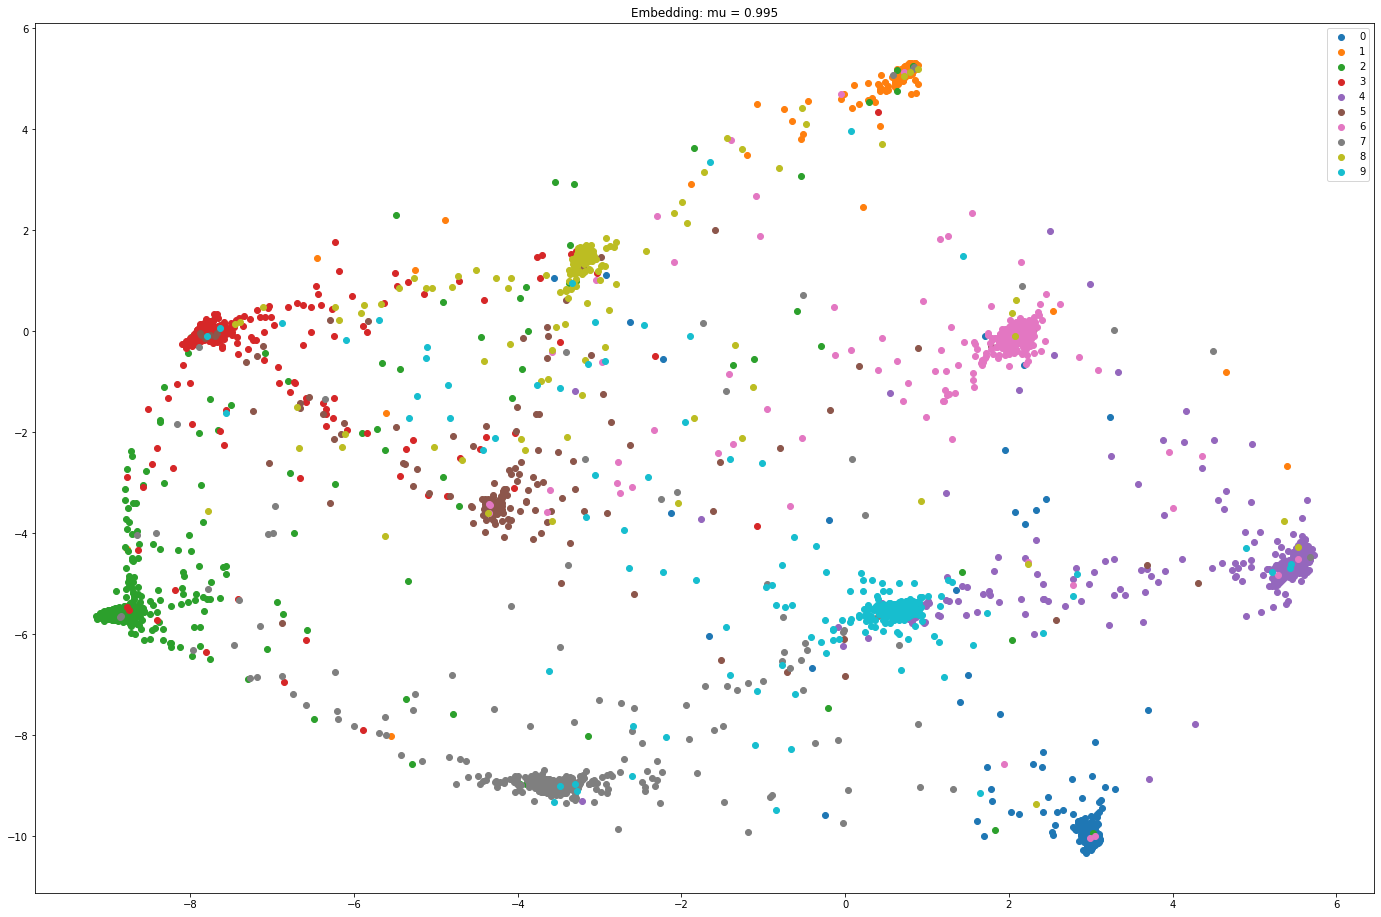

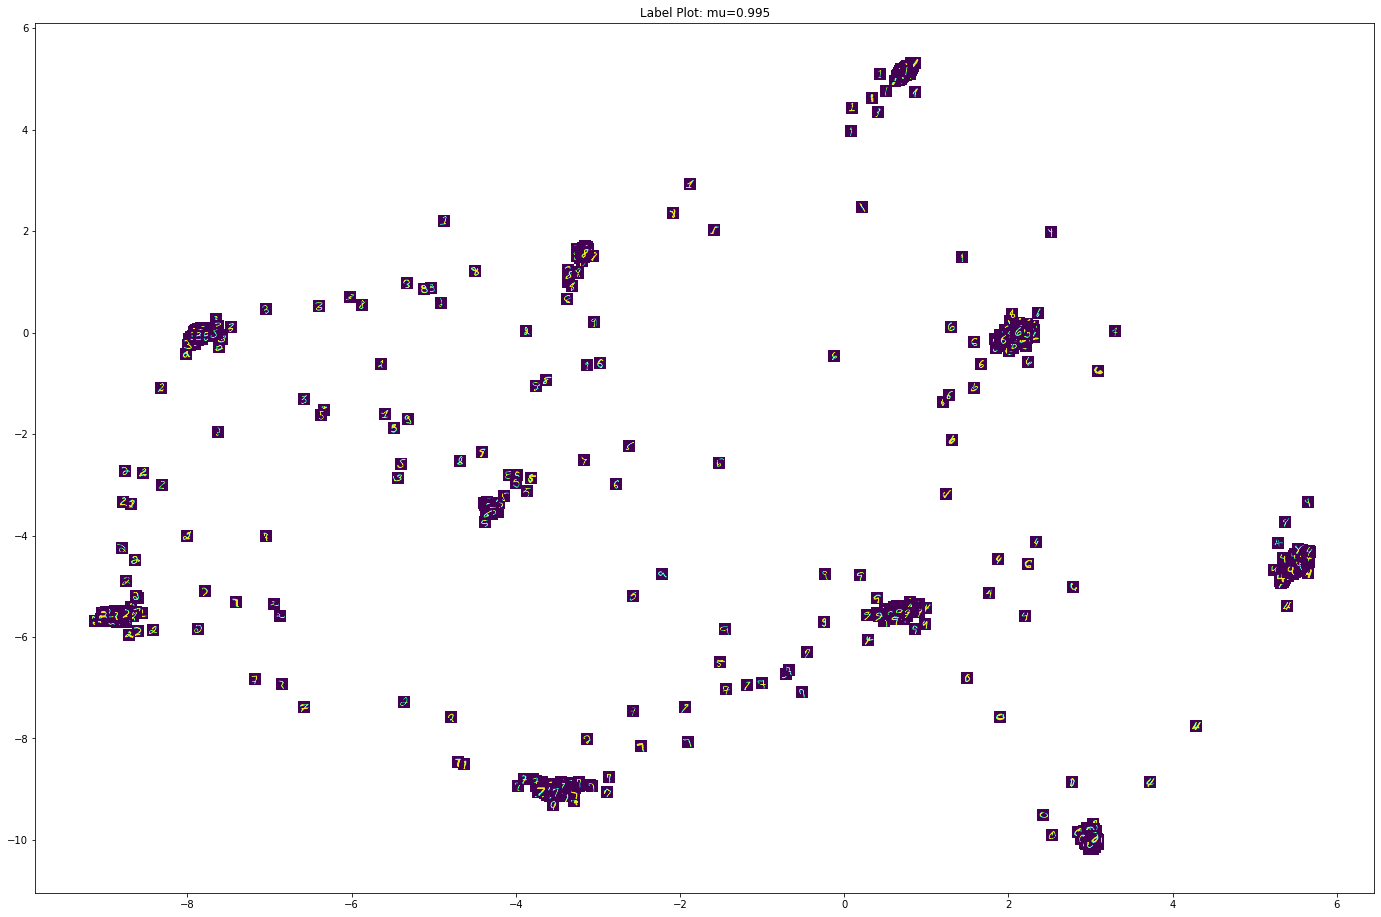

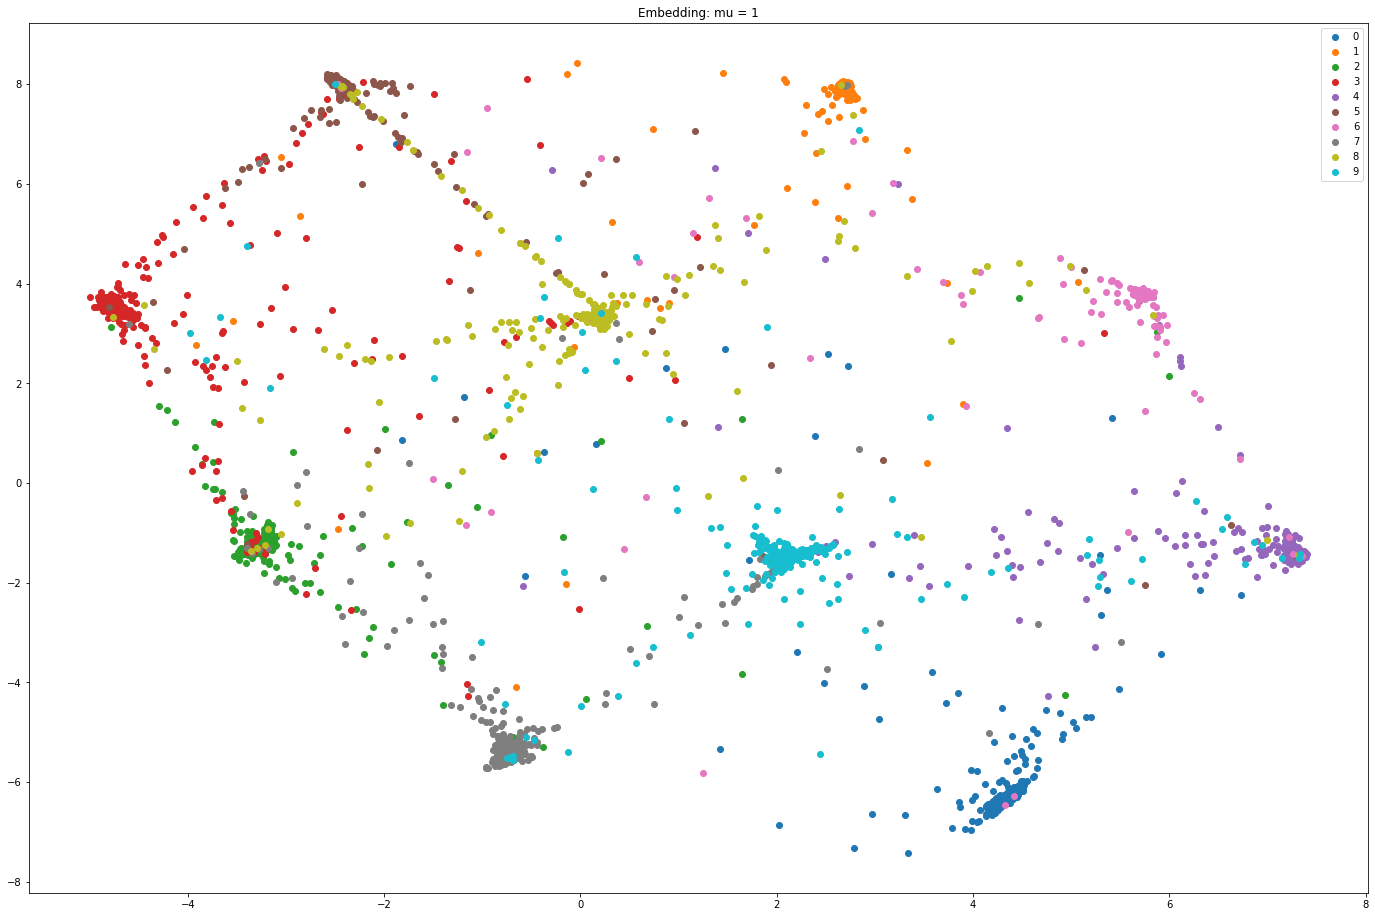

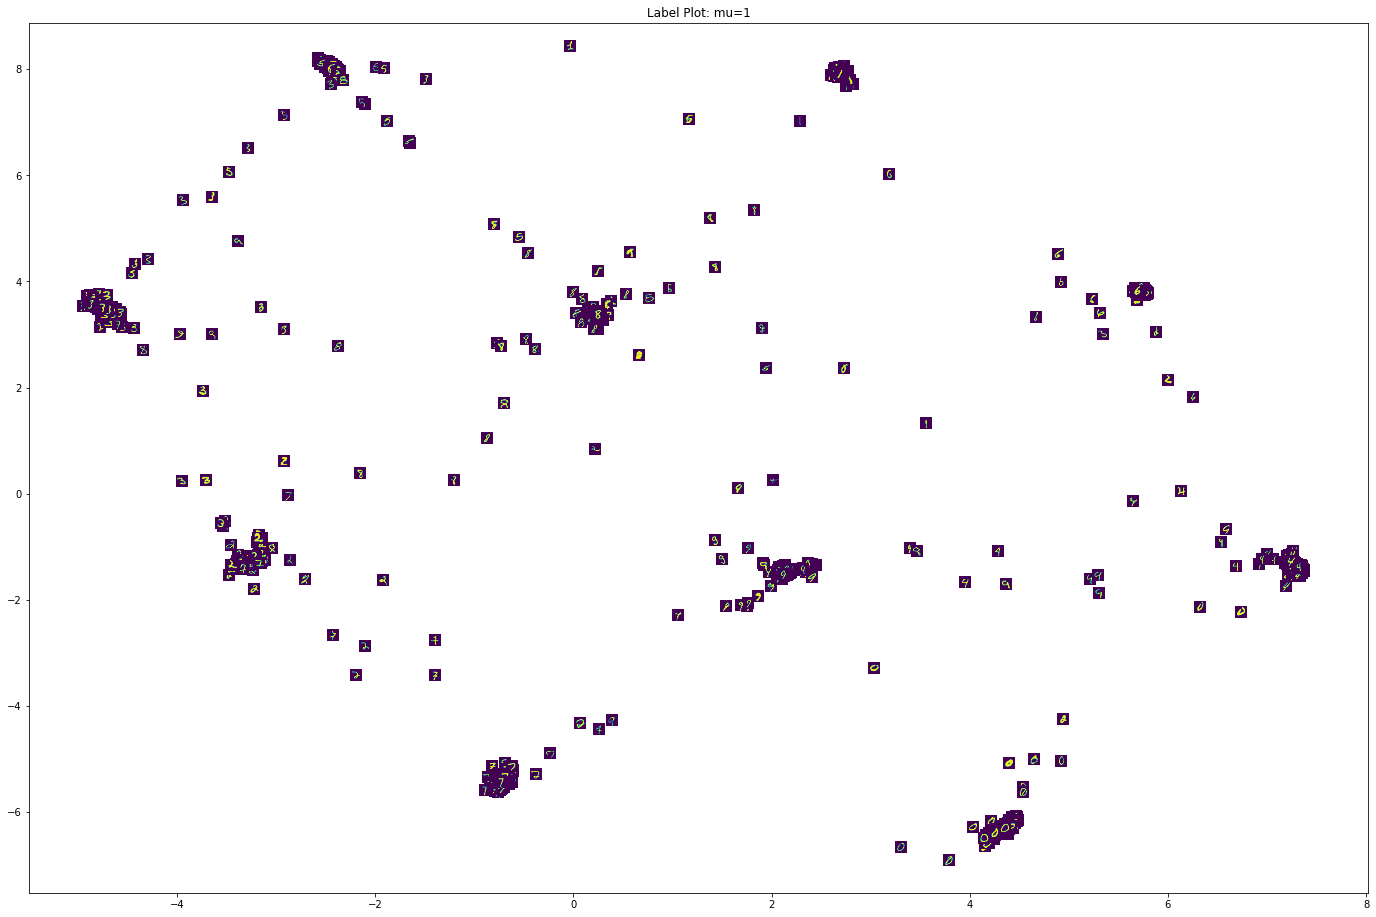

In [ ]:
# for mu, result in zip(mu_vals, results):
#     embedding, testX, testY = result[0], result[1], result[2]
#     plot_embedding(embedding, testY, mu)
#     label_plot(testX, embedding, testY, 200, mu)


In [ ]:
## get label plot 
label_plot(testX, embedding, testY, 200)

In [8]:
name = 'mnist'
size = 50000
X, Y = get_dataset(name, size)

## Specific modifications to MNIST. 
if name == 'mnist':
    target = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    inds = np.where(np.isin(Y, target))[0]
    X = X[inds, :].astype(np.float64) 
    Y = Y[inds].astype(int)
    X = X/255.

## train-test split
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25, shuffle=True, stratify=Y)

## reshape to match input requirements. 
trainX = trainX.reshape(-1, 1, trainX.shape[1])
testX = testX.reshape(-1, 1, testX.shape[1])

11493376/11490434 [==============================] - 2s 0us/step


In [9]:
#### Autoencoder Initialization ####
## create autoencoder. 
tied_weights = True
autoenc_input_dim = (1, trainX.shape[-1])
autoenc_output_dim = 2
autoenc_activation = 'relu'
autoenc_optimizer = Adam(learning_rate=0.01)

autoencoder = create_autoencoder(autoenc_input_dim, autoenc_output_dim, 
                                [500, 100, 20, 4], 
                                loss='mean_squared_error',
                                f=autoenc_activation, 
                                optimizer=autoenc_optimizer,
                                reconstruction_activation='sigmoid',
                                tied=tied_weights,
                                compile_=True)

layers for tying:  [TensorShape([4, 2]), TensorShape([20, 4]), TensorShape([100, 20]), TensorShape([500, 100]), TensorShape([784, 500])]


Train on 30000 samples, validate on 7500 samples
Epoch 1/350
30000/30000 [==============================] - 3s 89us/step - loss: 0.0754 - val_loss: 0.0636
Epoch 2/350
30000/30000 [==============================] - 1s 27us/step - loss: 0.0634 - val_loss: 0.0629
Epoch 3/350
30000/30000 [==============================] - 1s 26us/step - loss: 0.0612 - val_loss: 0.0574
Epoch 4/350
30000/30000 [==============================] - 1s 27us/step - loss: 0.0550 - val_loss: 0.0534
Epoch 5/350
30000/30000 [==============================] - 1s 27us/step - loss: 0.0525 - val_loss: 0.0516
Epoch 6/350
30000/30000 [==============================] - 1s 27us/step - loss: 0.0511 - val_loss: 0.0515
Epoch 7/350
30000/30000 [==============================] - 1s 27us/step - loss: 0.0505 - val_loss: 0.0507
Epoch 8/350
30000/30000 [==============================] - 1s 27us/step - loss: 0.0498 - val_loss: 0.0491
Epoch 9/350
30000/30000 [==============================] - 1s 26us/step - loss: 0.0493 - val_loss: 0.04

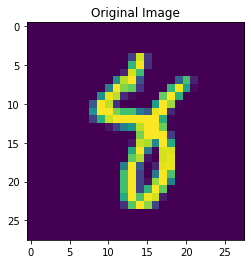

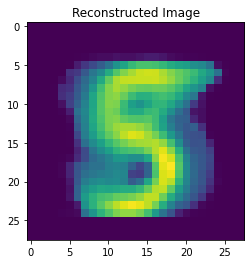

In [10]:
#### Autoencoder Training ####
## train autoencoder. 
history = autoencoder.fit(trainX, trainX,
                          epochs=350,
                          batch_size=256,
                          validation_split = 0.2,
                          verbose=1,
                          use_multiprocessing=True
                          )

encoder = autoencoder.get_layer('encoder')
decoder = autoencoder.get_layer('decoder')



(12500, 1, 784)


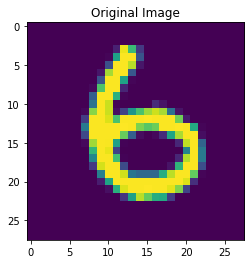

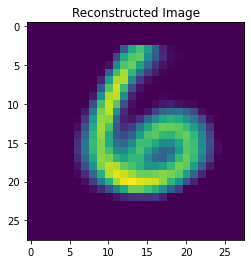

In [11]:
print(testX.shape)
sample = testX[10]

plt.figure()
plt.title('Original Image')
plt.imshow(sample.reshape(28, 28))
plt.show()

plt.figure() 
plt.title("Reconstructed Image")
predicted = autoencoder.predict(sample.reshape(-1, 1, 784))
plt.imshow(predicted.reshape(28, 28))
plt.show() 

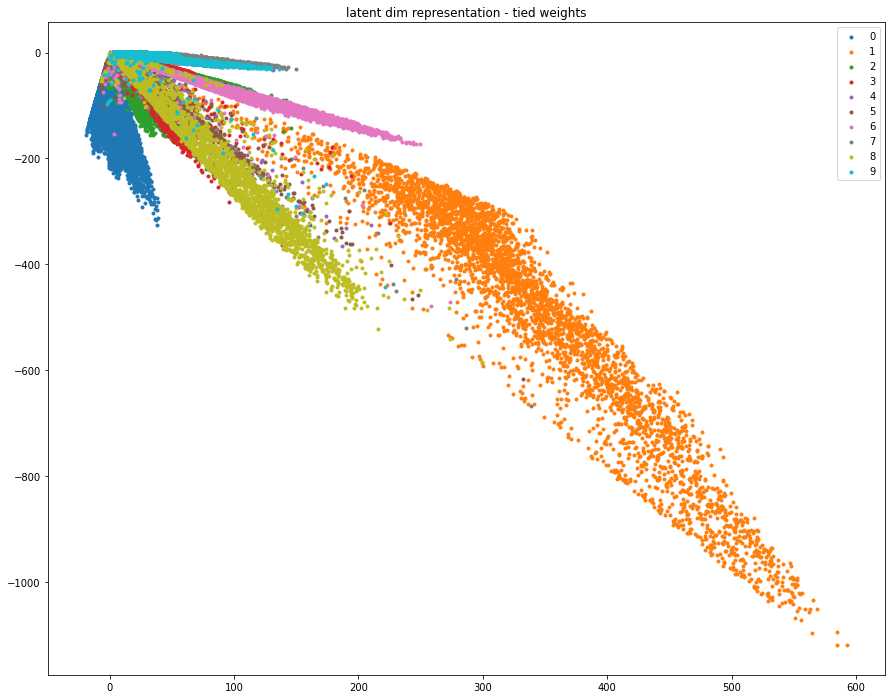

NameError: ignored

In [13]:
#### Autoencoder visualization ####
## transform the input space with autoencoder. 
encoder = autoencoder.get_layer("encoder")
X_tranf = encoder.predict(trainX)
X_tranf = X_tranf.reshape(-1, autoenc_output_dim)

## plot the latent dim embedding
plt.figure(figsize=(15,12)) 

for cl in set(trainY):
    inds = np.where(trainY == cl)[0]
    cl_data = X_tranf[inds, :]
    plt.scatter(cl_data[:, 0], cl_data[:, 1], label=cl, marker='.')

plt.legend() 
plt.title('latent dim representation - %s' %('tied weights' if tied_weights else 'untied weights'))
plt.show()


# ## pass testing set through encoder to get the low dim embeddings
# test_transf = encoder.predict(testX)

# ## now pass transformed test data through the siamese network to obtain contrastive embedding. 
# embedding = embedding_model.predict(test_transf)
# embedding = embedding.reshape(embedding.shape[0], embedding.shape[2])
# embedding_fig = test_embedding(test_transf, testY, embedding)